# Проект по основам машинного обучения

**Сеть фитнес-центров разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных. Распространённая проблема фитнес-клубов и других сервисов — отток клиентов.**

**Задача — провести анализ и подготовить план действий по удержанию клиентов, а именно:**
-	научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
-	проанализировать основные признаки, наиболее сильно влияющие на отток;
-	сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами: 
    -	1) выделить целевые группы клиентов;
    -	2) предложить меры по снижению оттока;
    -	3) определить другие особенности взаимодействия с клиентами.


**Оглавление**
1. [Открытие данных](#start)
3. [EDA Анализ признаков](#eda)
4. [Модель прогнозирования оттока пользователей](#model)
5. [Кластеризация пользователей](#klaster)
6. [Общий вывод и рекомендации](#output)

## Открытие данных
<a id="start"></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import os

In [2]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

**В нашем распоряжении датафрейм с даными пользователей фитнес-клуба:**


**Текущие поля в датасете:**

-	Данные пользователя за предыдущий до проверки факта оттока месяц: 
    -	'gender' — пол
    -	'Near_Location' — проживание или работа в районе, где находится фитнес-центр
    -	'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
    -	Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
    -	'Phone' — наличие контактного телефона
    -	'Age' — возраст
    -	'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)
-	Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
    -	'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
    -	'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
    -	'Group_visits' — факт посещения групповых занятий
    -	'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
    -	'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
    -	'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон
    -	'Churn' — факт оттока в текущем месяце;

### Предобработка данных

Приведем названия столбцов к привычному виду:

In [4]:
def rename(df):
    df = df.copy()
    df.columns  = df.columns.str.lower().str.replace(' ', '_')
    return df

df = rename(df)

Посмотрим пропуски:

In [5]:
round((df.isna().mean()*100),2)

gender                               0.0
near_location                        0.0
partner                              0.0
promo_friends                        0.0
phone                                0.0
contract_period                      0.0
group_visits                         0.0
age                                  0.0
avg_additional_charges_total         0.0
month_to_end_contract                0.0
lifetime                             0.0
avg_class_frequency_total            0.0
avg_class_frequency_current_month    0.0
churn                                0.0
dtype: float64

In [6]:
# Код ревьюера
df.isnull().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

Проверка на наличие дубликатов:

In [7]:
df.duplicated().sum()

0

В ходе предобработки поменяли названия столбцов, проверили пропуски и явные дубликаты в данных.

## EDA (Exploratory Data Analysis) Анализ признаков
<a id="eda"></a>

### Общий анализ

In [8]:
df.shape

(4000, 14)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Датафрем из 4000 строк, 14 столбцов. Пропусков нет, дубликатов нет, и все признаки в числовом виде. 
Рассмотрим данные повнимательнее:

In [10]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


С полом все понятно, 1 (допустим, мужской) или 0 (женский). С локацией тоже все прозрачно, либо в районе фитнес-центра либо нет. То же самое с колонками "partner", "promo_friends", "phone", "group_visits". Максимальный срок договора - год. Варианты начинаются с колонки возраста посетителей, суммарной выручки от других услуг фитнес-центра, частоты посещений в неделю и lifetime пользователя. Факт оттока тоже без сюрпризов - либо ушел, либо остался.

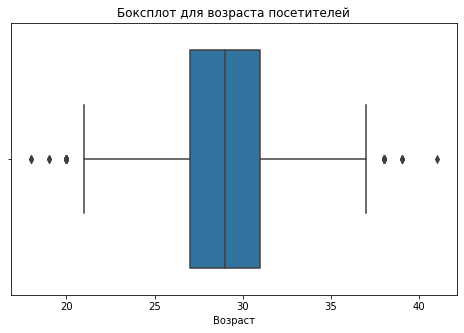

In [11]:
plt.figure(figsize=(8,5))
ax = sns.boxplot(x='age', data=df);
ax.set_title("Боксплот для возраста посетителей")
ax.set_xlabel("Возраст");

Возраст от 18 до 41 года.

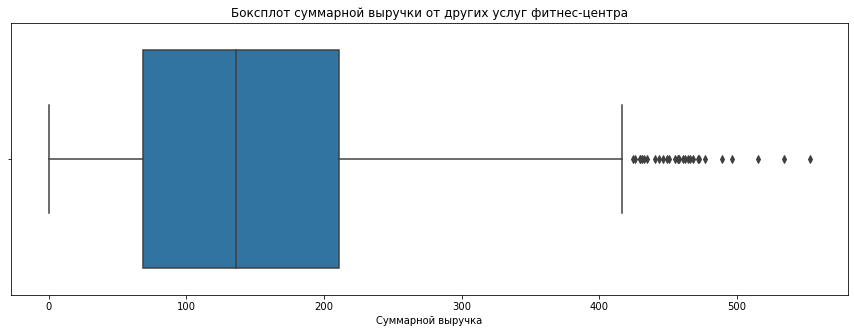

In [12]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(x='avg_additional_charges_total', data=df);
ax.set_title("Боксплот суммарной выручки от других услуг фитнес-центра")
ax.set_xlabel("Суммарная выручка");

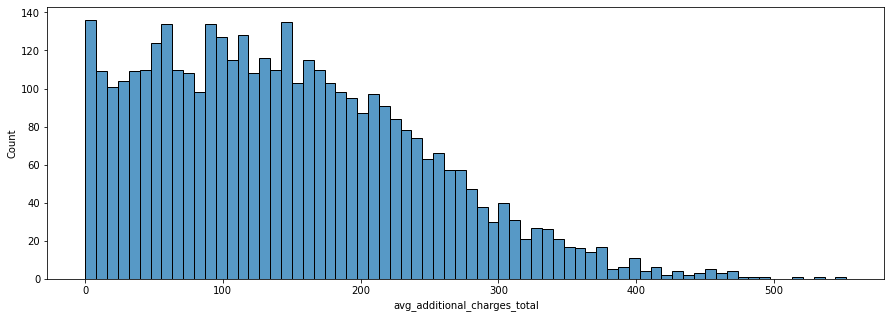

In [13]:
plt.figure(figsize=(15,5))
sns.histplot(df['avg_additional_charges_total'], bins=70);
ax.set_title("Гистограмма суммарной выручки от других услуг фитнес-центра")
ax.set_ylabel("Встречаемость значений")
ax.set_xlabel("Суммарная выручка");

Здесь вариантов побольше, присутствуют выбросы. Среднее - 147, медиана - 136 рублей.

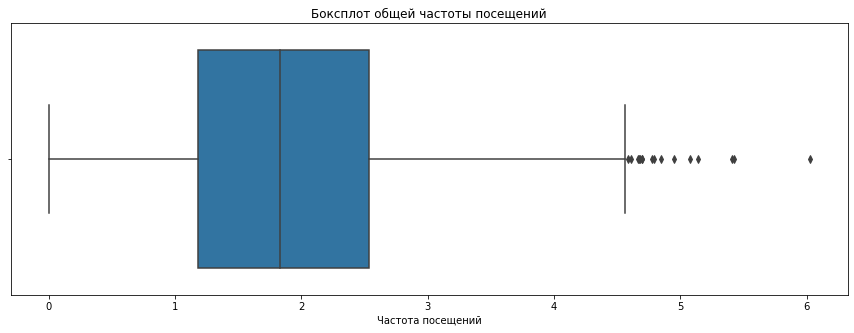

In [14]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(x='avg_class_frequency_total', data=df);
ax.set_title("Боксплот общей частоты посещений")
ax.set_xlabel("Частота посещений");

Понятно, что мало кто ходит каждый день, но и такие встречаются. Среднее - 1,8. 

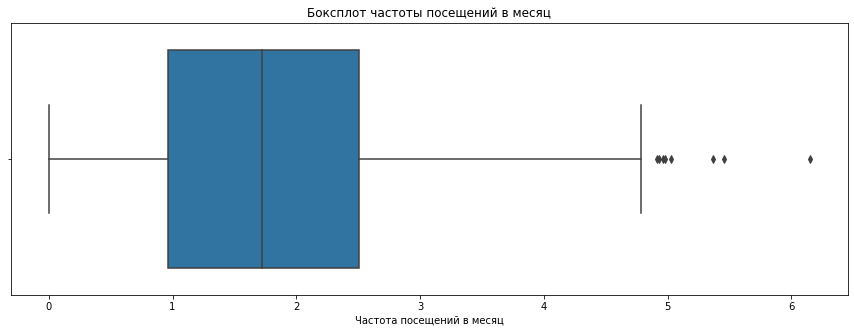

In [15]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(x='avg_class_frequency_current_month', data=df);
ax.set_title("Боксплот частоты посещений в месяц")
ax.set_xlabel("Частота посещений в месяц");

Немногим отличается от общей частоты, среднее - 1,7.

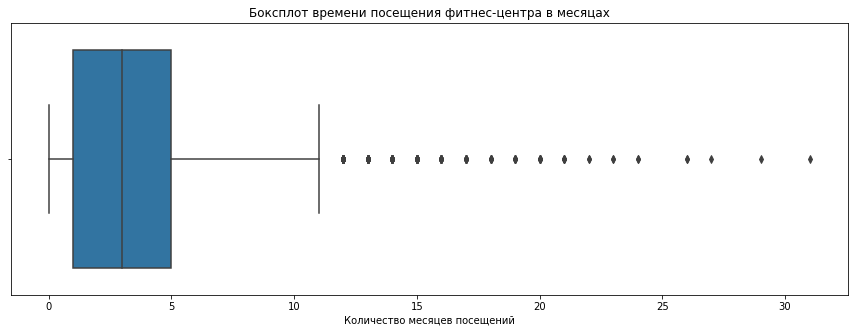

In [16]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(x='lifetime', data=df);
ax.set_title("Боксплот времени посещения фитнес-центра в месяцах")
ax.set_xlabel("Количество месяцев посещений");

Немногие ходят больше года. В основном, людей хватает на 3-4 месяца тренировок.

### Средние значения признаков

Посмотрим средние значения в группах по оттоку посетителей:

In [17]:
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Остающиеся посетители чаще являются сотрудниками компании-партнера клуба и заключают договор с клубом на более длительный срок. Естественно, они так же чаще ходят и "время жизни" у них выше.

### Гистограммы признаков

Сравним гистограммы признаков оставшихся и ушедштх постителей:

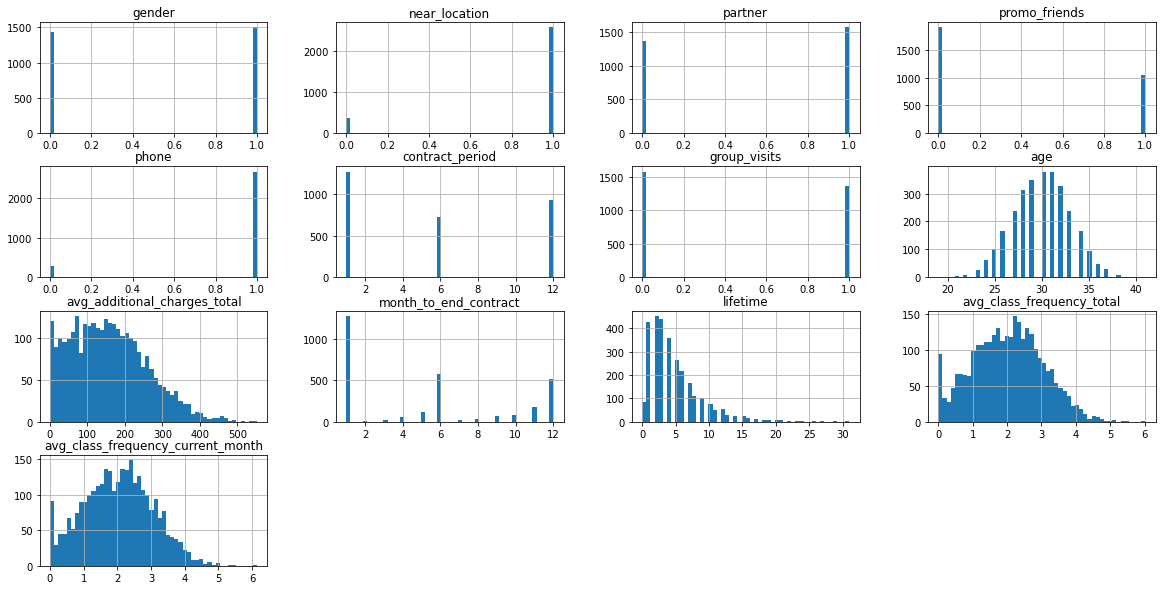

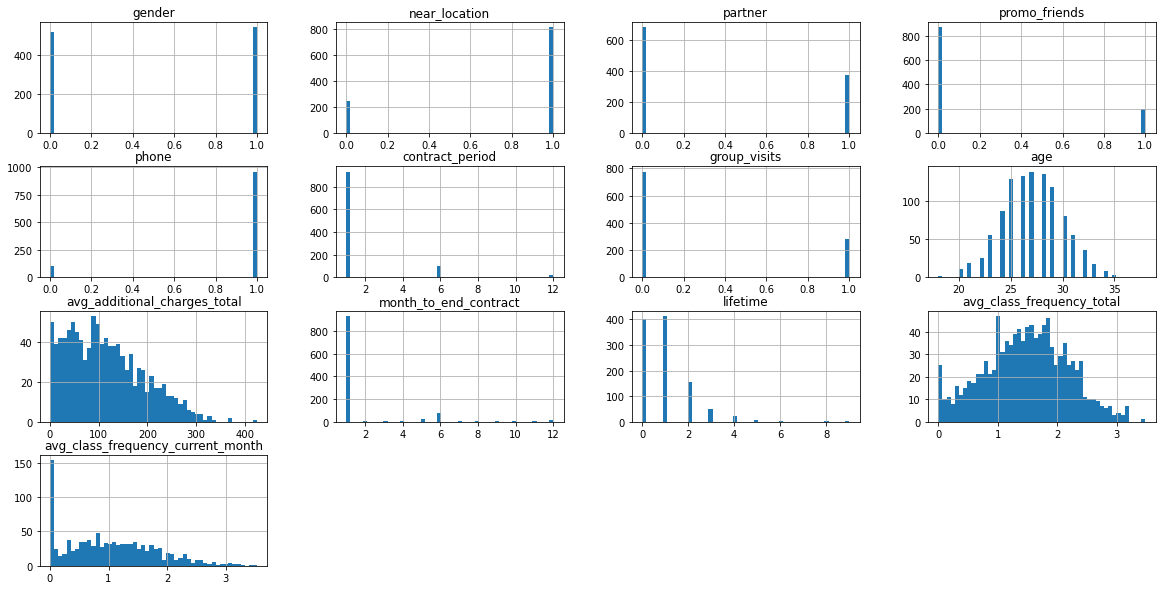

In [18]:
for name, group_data in df.groupby('churn'):   
    group_data.hist(df.drop('churn', axis=1).columns, bins=50, figsize=(20, 10))
    plt.title(name)

В целом картина похожа, но, как и ожидалось, у меняющихся признаков в группе оставшихся и значения выше, и графики оживленнее.

Разделим датасет на ушедших и оставшихся:

In [20]:
df_churn = df.query('churn == 1')
df_not_churn = df.query('churn == 0')
df_churn.info()
df_not_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1061 entries, 7 to 3996
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             1061 non-null   int64  
 1   near_location                      1061 non-null   int64  
 2   partner                            1061 non-null   int64  
 3   promo_friends                      1061 non-null   int64  
 4   phone                              1061 non-null   int64  
 5   contract_period                    1061 non-null   int64  
 6   group_visits                       1061 non-null   int64  
 7   age                                1061 non-null   int64  
 8   avg_additional_charges_total       1061 non-null   float64
 9   month_to_end_contract              1061 non-null   float64
 10  lifetime                           1061 non-null   int64  
 11  avg_class_frequency_total          1061 non-null   float

Оставшихся почти в 3 раза больше! Хорошой знак для фитнес-центра.

In [21]:
df_not_churn.corr()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.004588,-0.017409,-0.002746,-0.008443,-0.002893,0.015434,0.014745,-0.013551,-0.005047,0.019150,0.018719,0.017506,NaN
near_location,0.004588,1.000000,-0.015871,0.198554,-0.013571,0.130844,0.147798,0.006876,0.023125,0.122438,0.022296,0.001698,0.000975,NaN
partner,-0.017409,-0.015871,1.000000,0.455108,0.021220,0.294745,-0.011820,-0.011818,-0.006994,0.280882,-0.013123,-0.019247,-0.020797,NaN
promo_friends,-0.002746,0.198554,0.455108,1.000000,-0.004713,0.217869,0.099610,-0.012915,-0.003494,0.212872,0.003754,-0.012794,-0.012416,NaN
phone,-0.008443,-0.013571,0.021220,-0.004713,1.000000,-0.007959,0.000789,-0.011362,0.004559,-0.012660,-0.026664,0.018325,0.019386,NaN
contract_period,-0.002893,0.130844,0.294745,0.217869,-0.007959,1.000000,0.126558,-0.021563,0.039649,0.967340,-0.001045,-0.006538,-0.005080,NaN
group_visits,0.015434,0.147798,-0.011820,0.099610,0.000789,0.126558,1.000000,0.015875,0.001929,0.118517,0.002835,0.005587,0.003851,NaN
age,0.014745,0.006876,-0.011818,-0.012915,-0.011362,-0.021563,0.015875,1.000000,-0.001919,-0.020407,-0.024132,0.023803,0.022948,NaN
avg_additional_charges_total,-0.013551,0.023125,-0.006994,-0.003494,0.004559,0.039649,0.001929,-0.001919,1.000000,0.044765,-0.007366,-0.006934,-0.004487,NaN
month_to_end_contract,-0.005047,0.122438,0.280882,0.212872,-0.012660,0.967340,0.118517,-0.020407,0.044765,1.000000,-0.008097,-0.016365,-0.015420,NaN


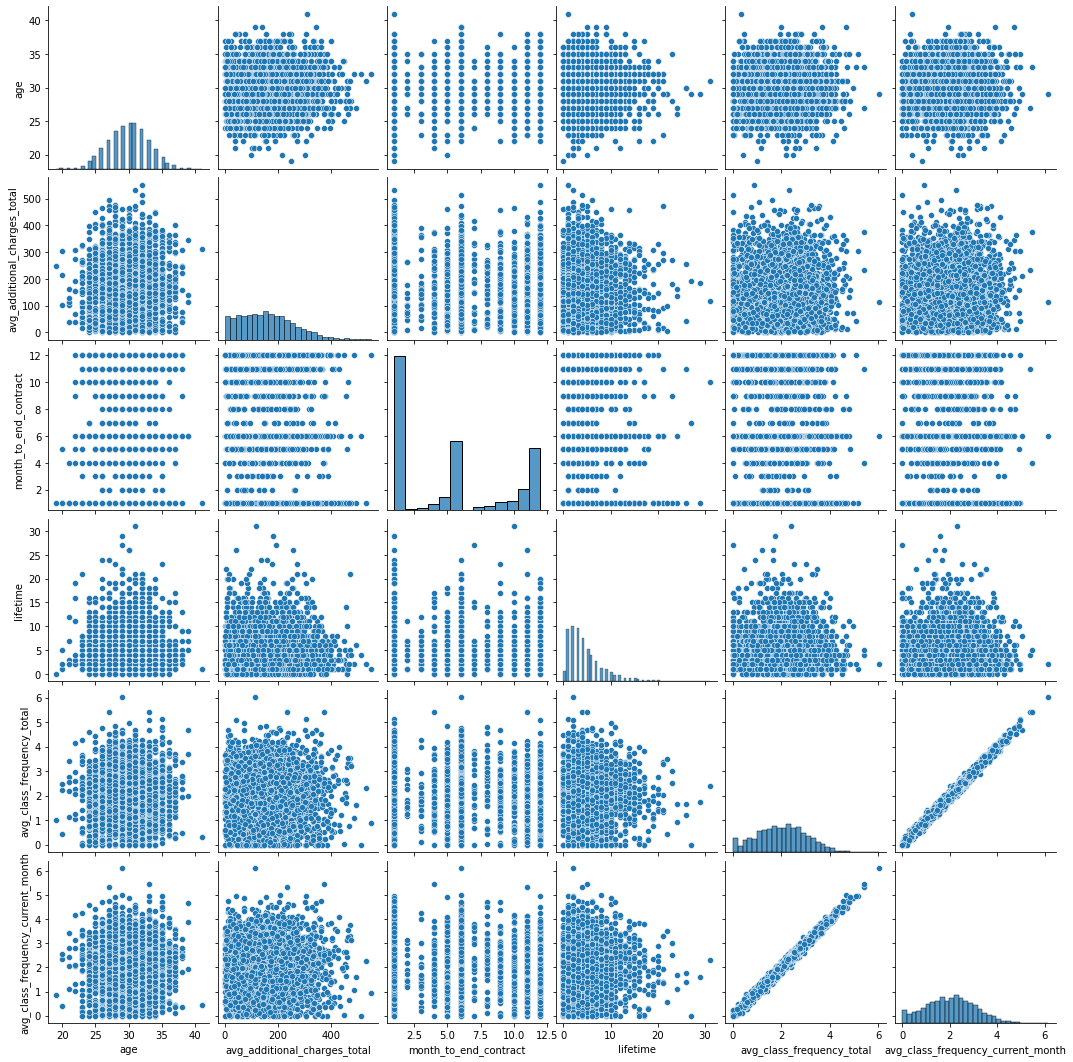

In [22]:
sns.pairplot(
    df_not_churn[['age', 'avg_additional_charges_total',
                           'month_to_end_contract', 'lifetime',
                           'avg_class_frequency_total',
                           'avg_class_frequency_current_month'
                          ]]
            )
plt.show() 

Сильно зависят друг от друга показатели средней частоты посещений за все время и за месяц, что не удивительно. У остальных признаков зависимость почти нулевая.

In [23]:
df_churn.corr()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.011913,0.009509,-0.012723,-0.008811,0.023992,0.027271,0.017344,0.005232,0.022929,-0.008307,0.002240,-0.015462,NaN
near_location,0.011913,1.000000,-0.049416,0.197275,-0.021734,0.058915,0.111250,0.008065,-0.003562,0.061410,-0.008687,0.044960,0.040668,NaN
partner,0.009509,-0.049416,1.000000,0.379864,-0.022625,0.172161,0.016582,-0.037490,-0.015331,0.167682,0.025813,0.001292,-0.025983,NaN
promo_friends,-0.012723,0.197275,0.379864,1.000000,0.024085,0.091260,0.074777,-0.032778,0.041355,0.087734,-0.020081,-0.014362,-0.024533,NaN
phone,-0.008811,-0.021734,-0.022625,0.024085,1.000000,-0.010393,-0.045483,-0.017676,0.026027,-0.015813,0.011553,-0.031635,-0.004533,NaN
contract_period,0.023992,0.058915,0.172161,0.091260,-0.010393,1.000000,0.035279,-0.040035,0.026716,0.982937,0.017638,0.045401,0.025777,NaN
group_visits,0.027271,0.111250,0.016582,0.074777,-0.045483,0.035279,1.000000,-0.004442,-0.022049,0.044576,-0.044651,0.050217,0.004890,NaN
age,0.017344,0.008065,-0.037490,-0.032778,-0.017676,-0.040035,-0.004442,1.000000,0.006157,-0.049213,0.060986,0.011902,0.006559,NaN
avg_additional_charges_total,0.005232,-0.003562,-0.015331,0.041355,0.026027,0.026716,-0.022049,0.006157,1.000000,0.027075,-0.035565,0.002112,0.006022,NaN
month_to_end_contract,0.022929,0.061410,0.167682,0.087734,-0.015813,0.982937,0.044576,-0.049213,0.027075,1.000000,0.009349,0.036355,0.019289,NaN


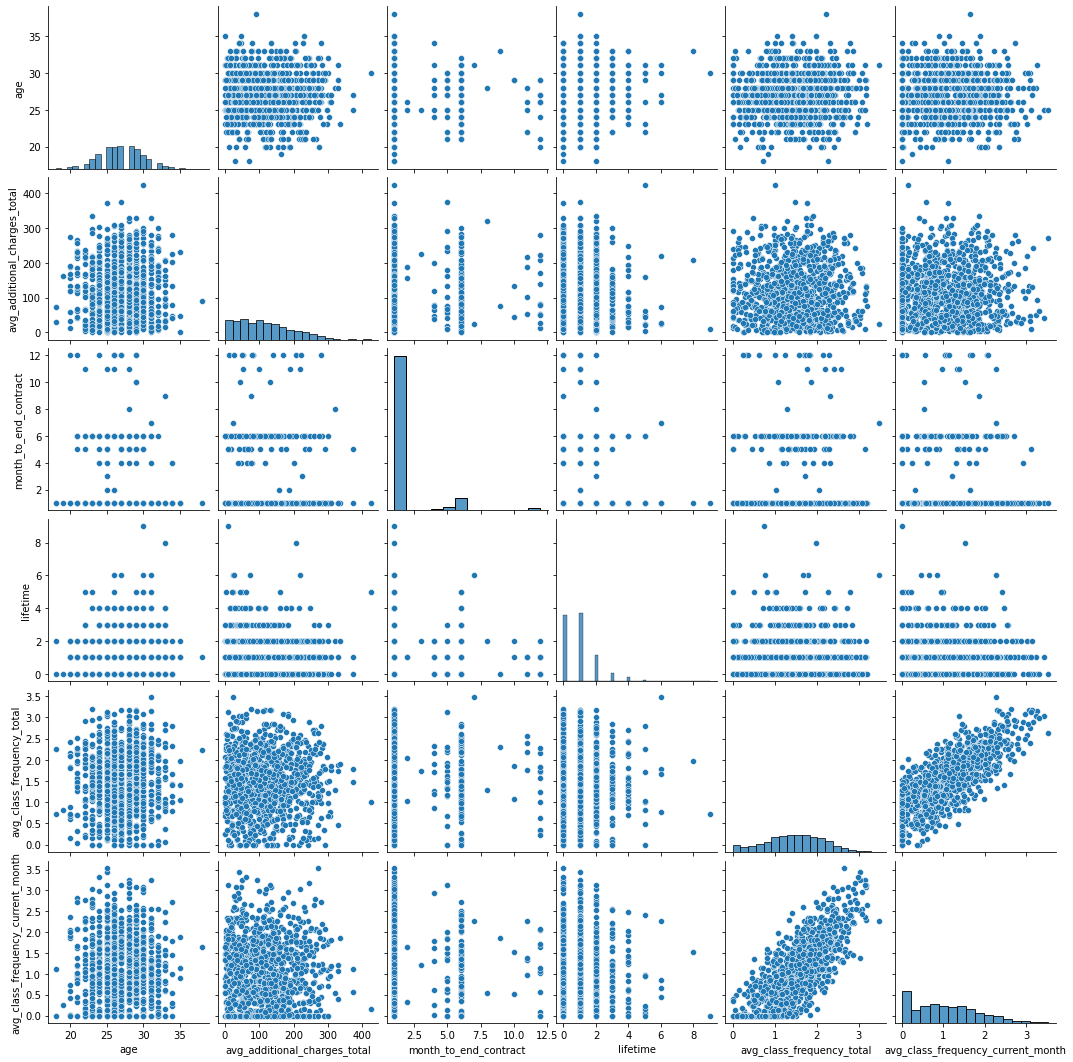

In [24]:
sns.pairplot(
    df_churn[['age', 'avg_additional_charges_total',
                           'month_to_end_contract', 'lifetime',
                           'avg_class_frequency_total',
                           'avg_class_frequency_current_month'
                          ]]
            )
plt.show() 

У ушедших картина в целом та же, но корреляция сильно завсимых признаков похуже (0.8)

### Матрица корреляций 

Общая матрица корреляции:

In [25]:
df.corr()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


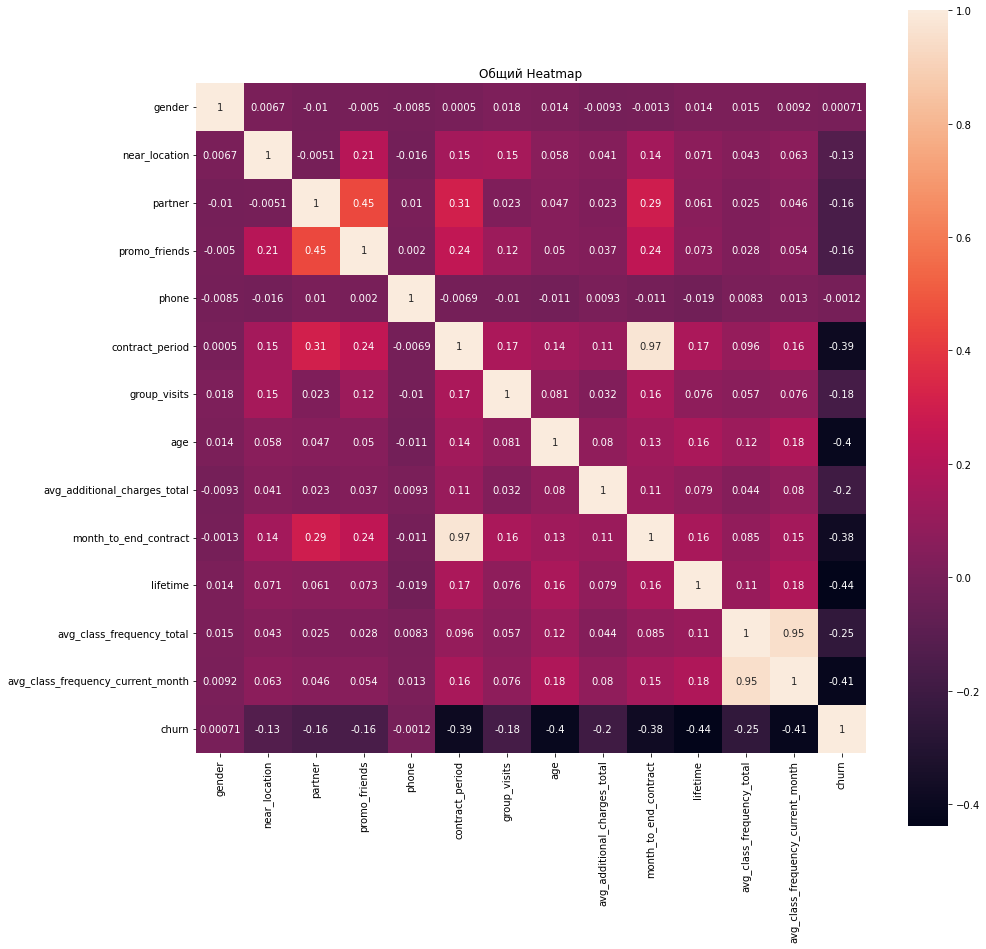

In [26]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), square = True, annot = True)
plt.title('Общий Heatmap')
plt.show()

На хетмапе гораздо лучше видно, что у нас не одна, а две пары сильнозависимых признаков - средняя частота посещений за все время и за месяц, а так же срок окончания от длительности текущего абонемента. Большинство признаков слабозависимы. Есть признаки с отрицательной корреляцией - например связи возраста, длительности абонемента, "время жизни" и частоты посещений клиента от показателя "оттока".

## Модель прогнозирования оттока пользователей
<a id="model"></a>

In [27]:
print('Размер датасета:', df.shape)

Размер датасета: (4000, 14)


In [28]:
print('Соотношение классов: \n', df['churn'].value_counts())

Соотношение классов: 
 0    2939
1    1061
Name: churn, dtype: int64


###  Разделение данных

In [29]:
X = df.drop('churn', axis=1)
y = df['churn']

In [30]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [31]:
X_train.shape

(3200, 13)

In [32]:
X_test.shape

(800, 13)

### Обучение модели

In [33]:
# Зададим алгиритмы
models = [
    LogisticRegression(solver='liblinear', random_state=0),
    RandomForestClassifier(n_estimators = 100, random_state = 0)
]

In [34]:
# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Метрики для модели:')
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_test, y_pred)))   
    

In [35]:
for i in models:
    print(i)
    make_prediction(i, X_train, y_train, X_test, y_test)

LogisticRegression(random_state=0, solver='liblinear')
Метрики для модели:
	Accuracy: 0.93
	Precision: 0.86
	Recall: 0.83
RandomForestClassifier(random_state=0)
Метрики для модели:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.82


### Оценка модели по метрикам

**Рассмотрим оценки модели по метрикам.**

Вспомним наши метрики: 
    Accuracy (доля правильных ответов): $$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$$
    Precision (точность): $$Precision = \frac{TP}{TP+FP}$$
    Recall (полнота): $$Recall = \frac{TP}{TP+FN}$$
   
   где фигурируют значения матрицы ошибок:
    $TP$ - True Positive, $TN$ - True Negative, $FP$ - False Positive и $FN$ - False Negative

**По полученным данным, модель логистической регрессии оказалась несколько лучше для данной задачи.** 

Метрики для модели логистической регрессии:	Accuracy: 0.93,	Precision: 0.86, Recall: 0.83
    
Метрики для модели случайного леса:    Accuracy: 0.92, 	Precision: 0.84, Recall: 0.82. 

**Однако не будем забывать, что мы не стандартизировали данные.**

## Кластеризация пользователей
<a id="klaster"></a>
Для кластеризации воспользуемся алгоритмом обучения без учителя "K-Means"

Сначала подготовим данные:

In [36]:
# еще раз убираем столбец оттока
X = df.drop('churn', axis=1)

In [37]:
# обязательная стандартизация данных 
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# подготовим матрицу признаков
linked = linkage(X_sc, method = 'ward') 

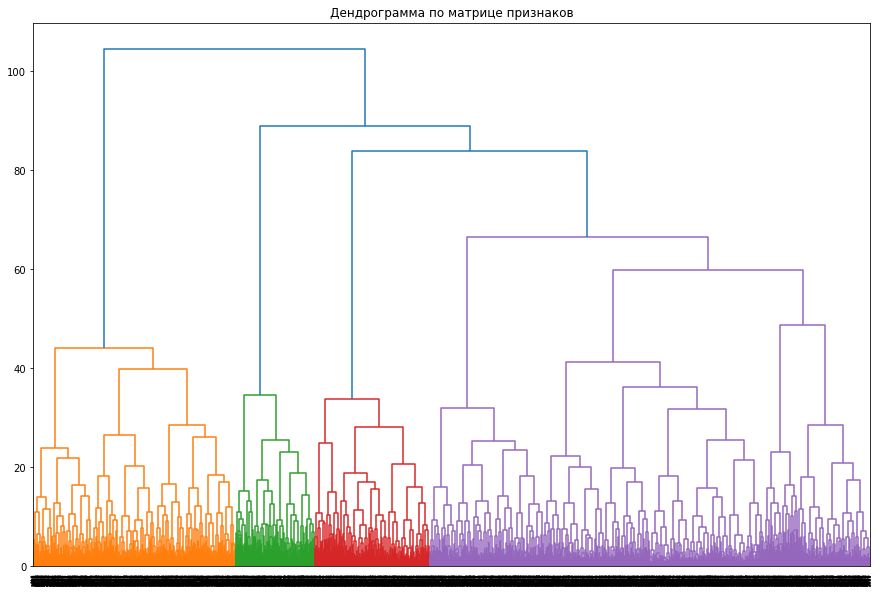

In [38]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма по матрице признаков')
plt.show() 

Очевидно, дендрограмма выделила нам 4 кластера пользователей. Но по условию задачи при дальнейшем обучении модели алгоритмом K-Means мы возьмем пять.

In [39]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)

In [40]:
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)

In [41]:
# сохраняем метки кластера в поле нашего датасета
df['cluster'] = labels

In [42]:
# выводим статистику по средним значениям наших признаков по кластеру
df.groupby(['cluster']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


По оттоку лучшие кластеры "0" и "4". Худший - третий. В первом нет телефонов :) По возрасту посетители распределены примерно одинаково. Средняя выручка от дополнительных услуг также различается незначительно.

Рассмотрим распределение признаков по кластерам более подробно:

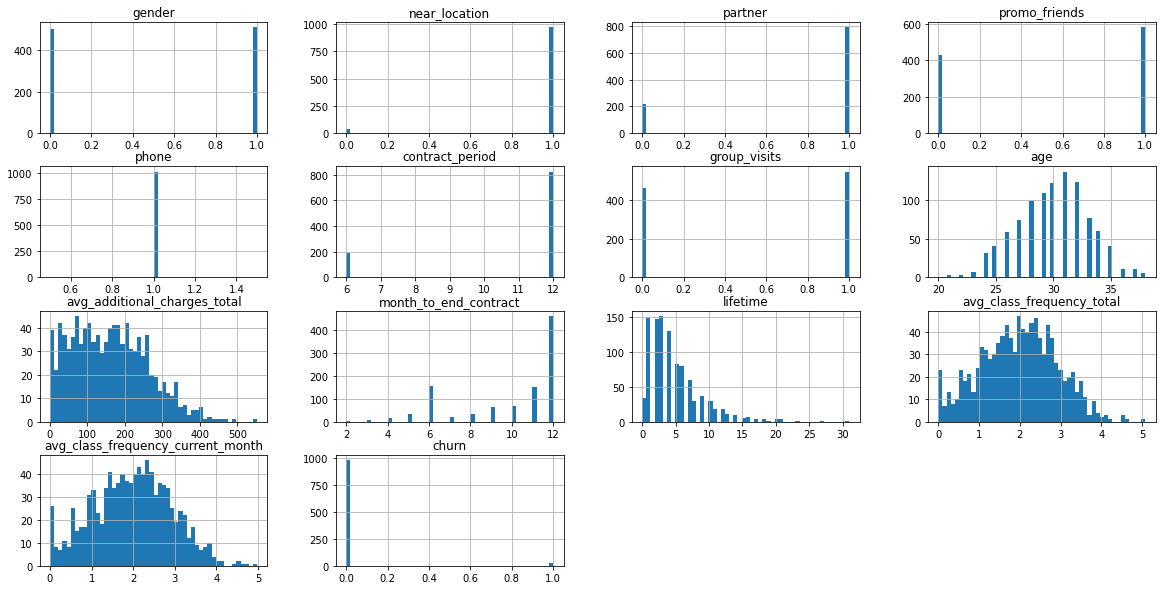

In [43]:
for name, group_data in df.query('cluster == 0').groupby('cluster'):   
    group_data.hist(df.query('cluster == 0').drop('cluster', axis=1).columns, bins=50, figsize=(20, 10))
    plt.title(name)

Признаки в нулевом кластере:
- почти все пользователи работают или живут рядом с фитнес-центром,
- многие работают в компаниях-партнерах,
- более половины пришли в рамках акции "приведи друга",
- абонемент в основном на год, 
- групповые визиты ~ 50/50, 
- возраст пользователей распределен нормально, 
- выручка от дополнительных услуг центра в основном от 0 до 300 рублей,
- остаток абонемента распределен по-разному, однако превалируют 6, 11 и 12 месяцев,
- "время жизни" в основном до полугода (5 месяцев), хотя есть и гости с показателем более 30 месяцев,
- частота посещений в неделю имеет нормальное распределение, среднее значение 2 раза в неделю,
- отток практически нулевой.

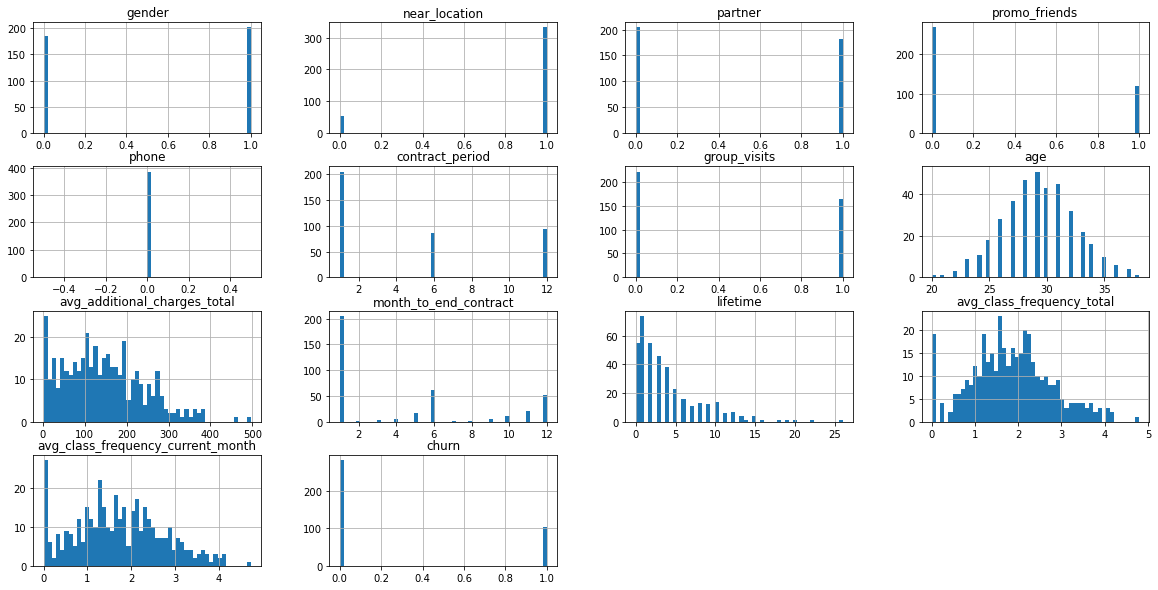

In [44]:
for name, group_data in df.query('cluster == 1').groupby('cluster'):   
    group_data.hist(df.query('cluster == 1').drop('cluster', axis=1).columns, bins=50, figsize=(20, 10))
    plt.title(name)

Признаки в первом кластере:
- большинство пользователей работают или живут рядом с фитнес-центром,
- многие работают в компаниях-партнерах,
- менее половины пришли в рамках акции "приведи друга",
- пользователи кластера не оставили контактных номеров телефонов,
- абонемент в основном на месяц, полгода и год, 
- групповые визиты ~ 40 %, 
- возраст пользователей распределен нормально, 
- выручка от дополнительных услуг центра в основном от 0 до 300 рублей,
- остаток абонемента в основном месяц, полгода и год,
- "время жизни" в основном от 0 до 10 месяцев, средний показатель 4 месяца,
- частота посещений в неделю имеет распределение близкое к нормальному, среднее значение чуть ниже нулевого кластера - 1.8,
- отток значительный - треть пользовтелей.

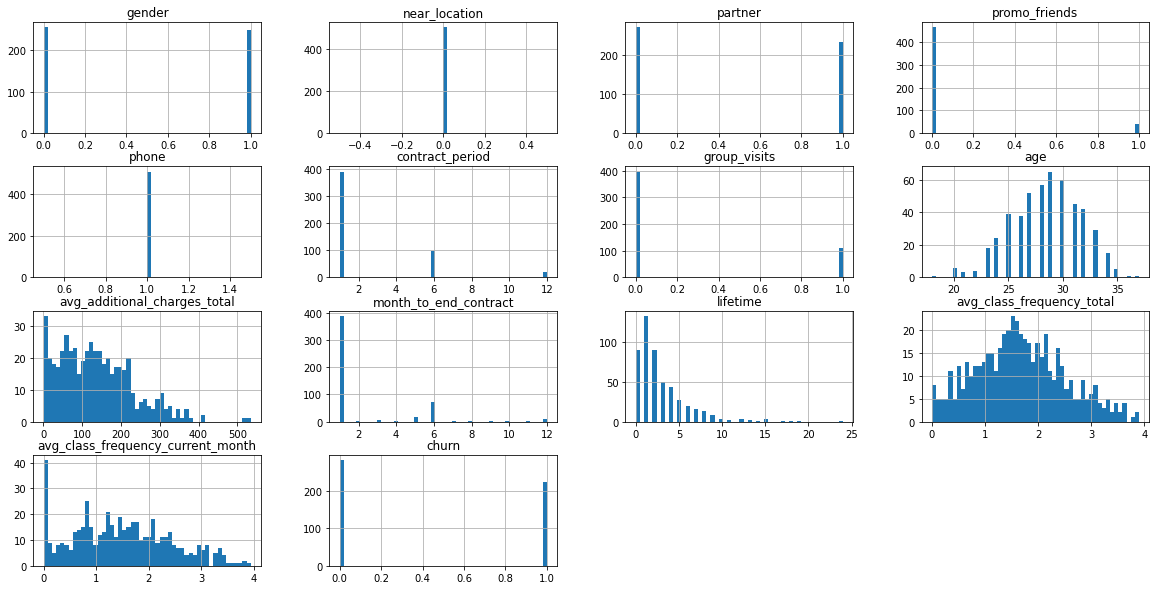

In [45]:
for name, group_data in df.query('cluster == 2').groupby('cluster'):   
    group_data.hist(df.query('cluster == 2').drop('cluster', axis=1).columns, bins=50, figsize=(20, 10))
    plt.title(name)

Признаки во втором кластере:
- пользователи работают или живут на удалении от фитнес-центра,
- приблизительно половина работает в компаниях-партнерах,
- очень немногие пришли в рамках акции "приведи друга",
- абонемент в основном на месяц, очень редко больше - полгода и год, 
- групповые занятия посещала примерно четверть пользователей, 
- возраст пользователей распределен нормально, 
- выручка от дополнительных услуг центра в основном от 0 до 200 рублей,
- остаток абонемента в основном меся и редко - полгода,
- "время жизни" в основном от 0 до 5 месяцев, средний показатель 3 месяца,
- частота посещений в неделю в среднем ~ 1.5 раза,
- отток значительный - 44 %.

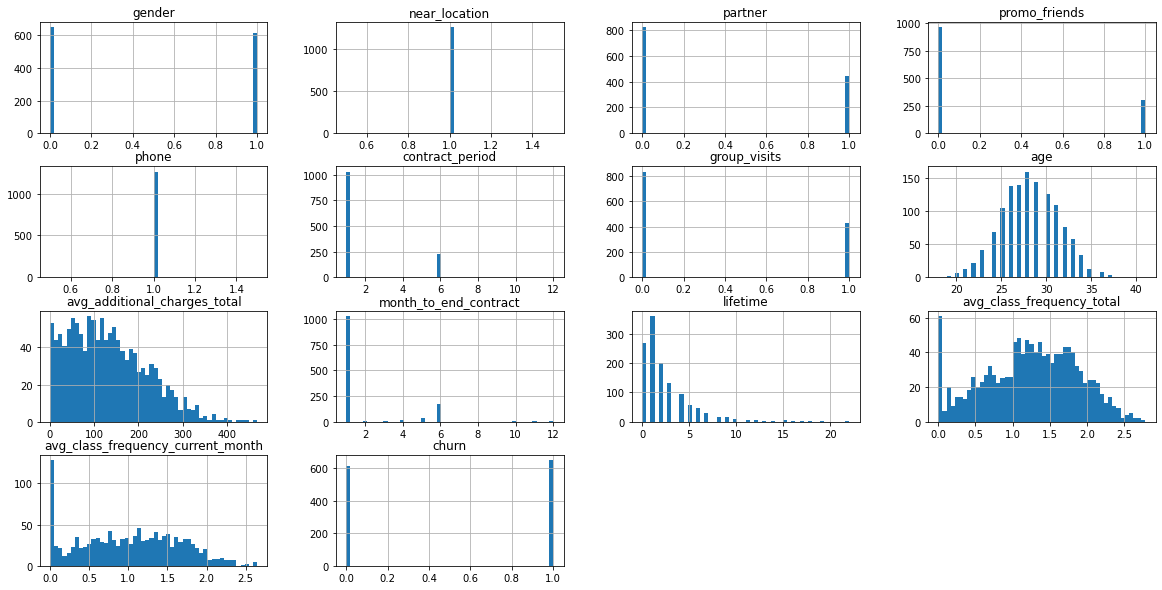

In [46]:
for name, group_data in df.query('cluster == 3').groupby('cluster'):   
    group_data.hist(df.query('cluster == 3').drop('cluster', axis=1).columns, bins=50, figsize=(20, 10))
    plt.title(name)

Признаки в третьем кластере:
- абсолютно все пользователи работают или живут рядом с фитнес-центром,
- треть работает в компаниях-партнерах,
- менее половины пришли в рамках акции "приведи друга",
- абонемент в основном на месяц, редко на полгода, 
- групповые занятия посещает приблизительно треть пользователей, 
- возраст пользователей распределен нормально, 
- выручка от дополнительных услуг центра в основном от 0 до 300 рублей,
- остаток абонемента в основном месяц и полгода,
- "время жизни" в основном от 0 до 5 месяцев, средний показатель 2,5 месяца,
- частота посещений в неделю примерно 1,
- отток максимальный среди остальных кластеров - половина пользователей.

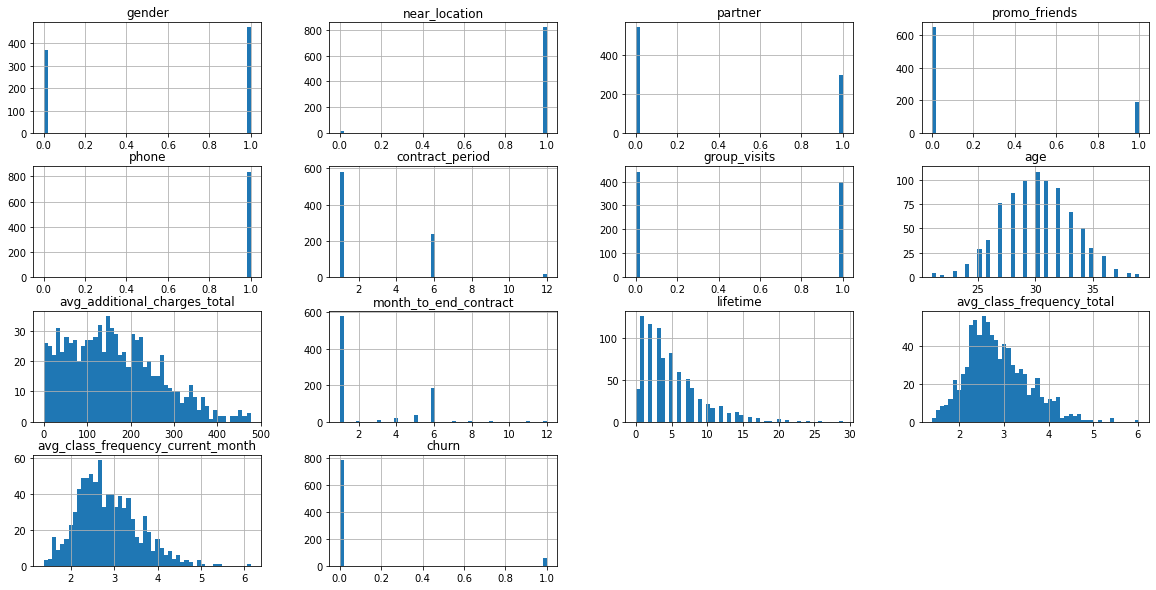

In [47]:
for name, group_data in df.query('cluster == 4').groupby('cluster'):   
    group_data.hist(df.query('cluster == 4').drop('cluster', axis=1).columns, bins=50, figsize=(20, 10))
    plt.title(name)

Признаки в последнем, четвертом кластере:
- почти все пользователи работают или живут рядом с фитнес-центром,
- треть работает в компаниях-партнерах,
- четверть пользователей пришла в рамках акции "приведи друга",
- абонемент в основном на месяц и полгода, 
- групповые визиты ~ 50/50, 
- возраст пользователей распределен нормально, 
- выручка от дополнительных услуг центра в основном от 0 до 300 рублей,
- остаток абонемента от месяца до полугода,
- "время жизни" в основном до полугода (5 месяцев), хотя есть и более высокие показатели,
- частота посещений в неделю 2-3 раза, максимальный показатель среди всех кластеров,
- отток незначительный - 7 процентов пользователей.

In [48]:
df.groupby(['cluster']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


## Общий вывод и рекомендации
<a id="output"></a>

**Итак, из пяти кластеров пользователей самые надежные в плане удержания - нулевой и четвертый. Средние показатели оттока в первом кластере, наихудшие результаты во втором и третьем.**

 В нулевом кластере собран "костяк" посетителей фитнес-центра - люди, которые ходят регулярно и с удовольствием, заключают договоры в основном на год вперед. В четвертом, судя по длительности абонементов, собраны мотивированные новички, они чаще других в среднем посещают спортзал. Оба кластера не очень нуждаются в поддержке, хотя и те и другие могут заинтересоваться более длительными сроками абонементов при предоставлении им специальных скидок.

В первом кластере собраны "середнячки" - люди, заинтересованные в посещении фитнес-центра, но посещающие его не так часто в силу различных причин - работа, учеба и т.д. Здесь значительный процент пользователей, посещающих груповые занятия (лучше только у нулевого кластера). Возможно, новые групповые программы позволят снизить отток пользователей этого кластера.

Во втором и третьем кластере собраны "проблемные" посетители - люди, пришедшие "попробовать", а так же сезонные гости "похудеть к лету", и не очень заинтересованные продолжать занятия. Во втором кластере проблема усугубляется удаленностью пользователей от фитнес-центра. Удержать людей этих кластеров довольно сложно, максимальный эффект могут дать кратковременные акции, что-нибудь из разряда "10 индивидуальных занятий с тренеров за полцены". Девушек из этих групп могут привлечь дополнительные косметические услуги - например массаж.

**Рекомендации:**
- необходимо продумать систему скидок на долгосрочные абонементы;
- рассмотреть возможность введения новых групповых занятий;
- ввести кратковременные акции для удержания "сезонных" посетителей;
- продумать целесообразность введения дополнительных косметических улуг;
- постараться расширить круг компаний-партнеров, это один из основных показателей появления "надежных" посетителей.
